In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# 1

The first website is given with url "https://www.topuniversities.com/university-rankings/world-university-rankings/2018". This is the main page for 2018 rankings and by default displays top 25 universities. Examining the HTML page served by the server, one cannot see university specific information given on the source code. Using postman (or any other tool with similar functionality) one can examine requests sent to the server and answers sent by the server. These answers include other file formats as well (i.e. images, stylesheets, scripts). Examining the answer of the server for the GET request with url of ranking, one can see that the server returns "https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt" file as well. Clicking the link and observing the structure of the data, one can see that it is a JSON file with names and features of the universities.

The code below sends request to get that JSON file using requests library. The text contained in the JSON is set to variable json1_text, and then using pandas functionality the first part of the JSON which contains data for universities (json1_text["data"]) is loaded to DataFrame for first num_of_rank = 200 universities. 

In [2]:
json1_url = "https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt"
r = requests.get(json1_url)
json1_text = r.json()

num_of_rank = 200
data1 = pd.DataFrame(data=json1_text["data"][0:num_of_rank], index=list(range(num_of_rank)))
print(data1.columns)

Index(['cc', 'core_id', 'country', 'guide', 'logo', 'nid', 'rank_display',
       'region', 'score', 'stars', 'title', 'url'],
      dtype='object')


The columns of the DataFrame are listed above, the unnecessary columns are dropped, then the head of the DataFrame is displayed.

In [3]:
data1.drop(['cc', 'core_id', 'guide', 'logo', 'nid', 'stars'], axis=1, inplace=True)

In [4]:
data1.head(10)

,country,rank_display,region,score,title,url
0,United States,1,North America,100,Massachusetts Institute of Technology (MIT),/universities/massachusetts-institute-technolo...
1,United States,2,North America,98.7,Stanford University,/universities/stanford-university
2,United States,3,North America,98.4,Harvard University,/universities/harvard-university
3,United States,4,North America,97.7,California Institute of Technology (Caltech),/universities/california-institute-technology-...
4,United Kingdom,5,Europe,95.6,University of Cambridge,/universities/university-cambridge
5,United Kingdom,6,Europe,95.3,University of Oxford,/universities/university-oxford
6,United Kingdom,7,Europe,94.6,UCL (University College London),/universities/ucl-university-college-london
7,United Kingdom,8,Europe,93.7,Imperial College London,/universities/imperial-college-london
8,United States,9,North America,93.5,University of Chicago,/universities/university-chicago
9,Switzerland,10,Europe,93.3,ETH Zurich - Swiss Federal Institute of Techno...,/universities/eth-zurich-swiss-federal-institu...


Shape of the DataFrame is (200, 6), 200 universities with 6 fields for each university.

In [5]:
print(data1.shape)

(200, 6)


As it can be seen from the above, some of the information (such as total number of faculty, total number of students, number of international students, number of international faculty) is not contained in the JSON file. Clicking the url of any university on the ranking table and examining the page one can see that these data is contained is seperate webpages for each university. URL of these webpages follow the same pattern, url_base + url_tail where url_tail is the element of the DataFrame in the url column. Using requests library, we sent a requests to each of these webpages and using Beautiful Soup, we parsed the HTML to get the necessary fields. These fields in the HTML page are found by examining the HTML source code for universities webpages and saved into variables such as div1, div2, div3 and class_name. The following code takes these data and saves into the DataFrame.

In [6]:
data1 = data1.assign(total_faculty=0)
data1 = data1.assign(international_faculty=0)
data1 = data1.assign(total_student=0)
data1 = data1.assign(international_student=0)

url_base = "https://www.topuniversities.com"
div1 = '<div class="faculty-main wrapper col-md-4">'
div2 = '<div class="students-main wrapper col-md-4">'
div3 = '<div class="int-students-main wrapper col-md-4">'
class_name = ["faculty-main wrapper col-md-4", "students-main wrapper col-md-4", "int-students-main wrapper col-md-4"]

for i in data1.index:
    url_ = data1.iloc[i]['url']
    r = requests.get(url_base + url_)
    soup = BeautifulSoup(r.text, 'html.parser')
    lst = []
    for ic, c in enumerate(class_name):
        a = soup.findAll("div", { "class" : c})
        if len(a) > 0:
            for j in a[0].findAll("div", { "class" : "number" }):
                lst.append(int(''.join(ch for ch in j.get_text() if ch.isdigit())))
        if ic == 0:
            lst += [np.nan] * (2-len(lst))
        if ic == 1:
            lst += [np.nan] * (3-len(lst))
        if ic == 2:
            lst += [np.nan] * (4-len(lst))                
    data1.loc[i, ['total_faculty', 'international_faculty', 'total_student', 'international_student']] = lst

Note that, after that step some universities have nan values in some of its columns. NYU has no information for any of the fields related to number of faculty and student. IISc Bangalore has no information for number of international faculty.

In [7]:
data1.head(10)

,country,rank_display,region,score,title,url,total_faculty,international_faculty,total_student,international_student
0,United States,1,North America,100,Massachusetts Institute of Technology (MIT),/universities/massachusetts-institute-technolo...,2982.0,1679.0,11067.0,3717.0
1,United States,2,North America,98.7,Stanford University,/universities/stanford-university,4285.0,2042.0,15878.0,3611.0
2,United States,3,North America,98.4,Harvard University,/universities/harvard-university,4350.0,1311.0,22429.0,5266.0
3,United States,4,North America,97.7,California Institute of Technology (Caltech),/universities/california-institute-technology-...,953.0,350.0,2255.0,647.0
4,United Kingdom,5,Europe,95.6,University of Cambridge,/universities/university-cambridge,5490.0,2278.0,18770.0,6699.0
5,United Kingdom,6,Europe,95.3,University of Oxford,/universities/university-oxford,6750.0,2964.0,19720.0,7353.0
6,United Kingdom,7,Europe,94.6,UCL (University College London),/universities/ucl-university-college-london,6345.0,2554.0,31080.0,14854.0
7,United Kingdom,8,Europe,93.7,Imperial College London,/universities/imperial-college-london,3930.0,2071.0,16090.0,8746.0
8,United States,9,North America,93.5,University of Chicago,/universities/university-chicago,2449.0,635.0,13557.0,3379.0
9,Switzerland,10,Europe,93.3,ETH Zurich - Swiss Federal Institute of Techno...,/universities/eth-zurich-swiss-federal-institu...,2477.0,1886.0,19815.0,7563.0


In [8]:
data1[data1.isnull().any(axis=1)]

,country,rank_display,region,score,title,url,total_faculty,international_faculty,total_student,international_student
51,United States,52,North America,77.3,New York University (NYU),/universities/new-york-university-nyu,NaN,NaN,NaN,NaN
189,India,190,Asia,49,Indian Institute of Science (IISc) Bangalore,/universities/indian-institute-science-iisc-ba...,423.0,NaN,4071.0,47.0


Some cleaning and transformation for the DataFrame. url column is now unnecessary, drop the column. Change some of the column names (rank_display -> rank, title -> name). Column rank has non-digit characters (such as "=") which symbolizes the case of tie, these are unnecessary. Change the order of columns. At the end, transform columns to numeric data if possible. After all, data from the first website is ready to use in data analysis.

In [9]:
data1.drop(["url"], axis=1, inplace=True)
data1.rename(columns={'rank_display': 'rank', 'title': 'name'}, inplace=True)
data1["rank"] = data1["rank"].apply(lambda x: re.sub("[^0-9]", "", x))
data1 = data1[["name", "country", "region", "rank", "score", "international_faculty", "total_faculty", "international_student", "total_student"]]
data1 = data1.apply(pd.to_numeric, errors="ignore")

In [10]:
data1

,name,country,region,rank,score,international_faculty,total_faculty,international_student,total_student
0,Massachusetts Institute of Technology (MIT),United States,North America,1,100.0,1679.0,2982.0,3717.0,11067.0
1,Stanford University,United States,North America,2,98.7,2042.0,4285.0,3611.0,15878.0
2,Harvard University,United States,North America,3,98.4,1311.0,4350.0,5266.0,22429.0
3,California Institute of Technology (Caltech),United States,North America,4,97.7,350.0,953.0,647.0,2255.0
4,University of Cambridge,United Kingdom,Europe,5,95.6,2278.0,5490.0,6699.0,18770.0
5,University of Oxford,United Kingdom,Europe,6,95.3,2964.0,6750.0,7353.0,19720.0
6,UCL (University College London),United Kingdom,Europe,7,94.6,2554.0,6345.0,14854.0,31080.0
7,Imperial College London,United Kingdom,Europe,8,93.7,2071.0,3930.0,8746.0,16090.0
8,University of Chicago,United States,North America,9,93.5,635.0,2449.0,3379.0,13557.0
9,ETH Zurich - Swiss Federal Institute of Techno...,Switzerland,Europe,10,93.3,1886.0,2477.0,7563.0,19815.0


# 1.a

Copy the DataFrame for the data in the first website and add new column for ratio of total_faculty to total_student. Sort the DataFrame with respect to ratio_faculty_student and then display the DataFrame for top 20 university with some of the columns.

In [11]:
data_1a = data1.copy()
data_1a["ratio_faculty_student"] = data_1a["total_faculty"] / data_1a["total_student"]
data_1a.sort_values("ratio_faculty_student", ascending=False, inplace=True)

In [12]:
data_1a[["rank", "country", "region", "name", "ratio_faculty_student"]].head(20)

,rank,country,region,name,ratio_faculty_student
3,4,United States,North America,California Institute of Technology (Caltech),0.422616
15,16,United States,North America,Yale University,0.398323
5,6,United Kingdom,Europe,University of Oxford,0.342292
4,5,United Kingdom,Europe,University of Cambridge,0.292488
16,17,United States,North America,Johns Hopkins University,0.276353
1,2,United States,North America,Stanford University,0.269870
0,1,United States,North America,Massachusetts Institute of Technology (MIT),0.269450
185,186,United States,North America,University of Rochester,0.266604
18,19,United States,North America,University of Pennsylvania,0.266437
17,18,United States,North America,Columbia University,0.247115


According to results, universities with high ratio of faculty to student generally ranked at the top places, although there are some universities (i.e. University of Rochester) with high ratio (=0.266604) and relatively low ranking (=186).

# 1.b

Copy the DataFrame for the data in the first website and add new column for ratio of international_student to total_student. Sort the DataFrame with respect to ratio_international_student and then display the DataFrame for top 20 university with some of the columns.

In [13]:
data_1b = data1.copy()
data_1b["ratio_international_student"] = data_1b["international_student"] / data_1b["total_student"]
data_1b.sort_values("ratio_international_student", ascending=False, inplace=True)

In [14]:
data_1b[["rank", "country", "region", "name", "ratio_international_student"]].head(20)

,rank,country,region,name,ratio_international_student
34,35,United Kingdom,Europe,London School of Economics and Political Scien...,0.691393
11,12,Switzerland,Europe,Ecole Polytechnique Fédérale de Lausanne (EPFL),0.570047
7,8,United Kingdom,Europe,Imperial College London,0.543567
198,200,Netherlands,Europe,Maastricht University,0.502533
47,47,United States,North America,Carnegie Mellon University,0.478062
6,7,United Kingdom,Europe,UCL (University College London),0.477928
91,92,United Kingdom,Europe,University of St Andrews,0.457955
41,41,Australia,Oceania,The University of Melbourne,0.427434
126,127,United Kingdom,Europe,Queen Mary University of London,0.421816
25,26,Hong Kong,Asia,The University of Hong Kong,0.407144


According to results, the correlation between having a high ratio of international students and ranking high is much smaller than the correlation between having high ratio of faculty to student and ranking high. The reason behind might be the methodology of ranking, given that higher ratio of faculty to student has higher weight in the overall score than higher ratio of international students the results we get makes sense.

# 1.c

Use the DataFrame in 1.a, group the data by country and take the mean of ratio_faculty_student column. The approach below takes the mean of ratios of all universities in the country for each country, instead of finding the total number of faculty and student in the country and then taking the ratio. The results are then showed using bar plot.

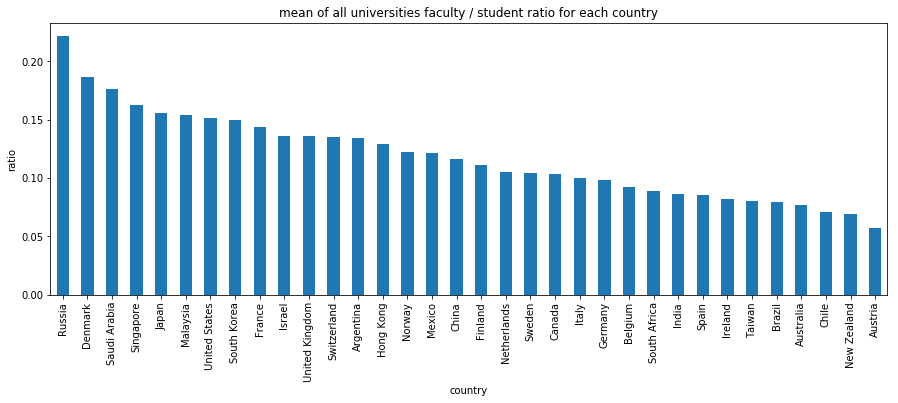

In [15]:
data_1c_1 = data_1a.groupby("country").agg("mean").sort_values("ratio_faculty_student", ascending=False)["ratio_faculty_student"]
ax = data_1c_1.plot.bar(y="ratio_faculty_student", figsize=(15, 5), title="mean of all universities faculty / student ratio for each country" )
ax.set_ylabel("ratio")
plt.show()

Use the DataFrame in 1.a, group the data by country and take the ratio of sum of total_faculty and total_student. The approach below finds the total number of international student and total student in the country and then takes their ratio. The results are then showed using bar plot.

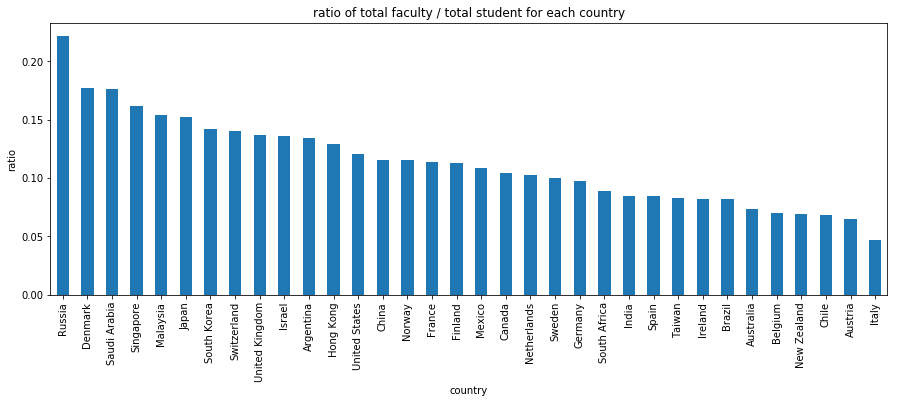

In [16]:
data_1c_11 = data_1a.groupby('country')['total_faculty'].sum().div(data_1a.groupby('country')['total_student'].sum()).sort_values(ascending=False)
ax = data_1c_11.plot.bar(y="ratio_faculty_student", figsize=(15, 5), title="ratio of total faculty / total student for each country" )
ax.set_ylabel("ratio")
plt.show()

According to results, Russia has the highest ratio of faculty to student. Denmark follows Russia and then Saudi Arabia comes third. There are several Asian countries following top 3. The United States and European countries are relatively low ratio of faculty to student. The underlying reason might be the different styles of lectures.

Use the DataFrame in 1.b, group the data by country and take the mean of ratio_international_student column. The approach below takes the mean of ratios of all universities in the country for each country, instead of finding the total number of international student and total student in the country and then taking the ratio. The results are then showed using bar plot.

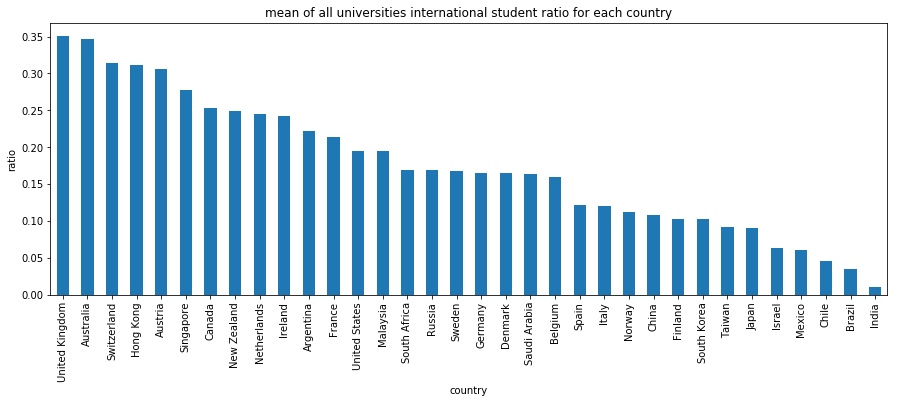

In [17]:
data_1c_2 = data_1b.groupby("country").agg("mean").sort_values("ratio_international_student", ascending=False)["ratio_international_student"]
ax = data_1c_2.plot.bar(y="ratio_international_student", figsize=(15, 5), title="mean of all universities international student ratio for each country" )
ax.set_ylabel("ratio")
plt.show()

Use the DataFrame in 1.b, group the data by country and take the ratio of sum of international_student and total_student. The approach below finds the total number of international student and total student in the country and then takes their ratio. The results are then showed using bar plot.

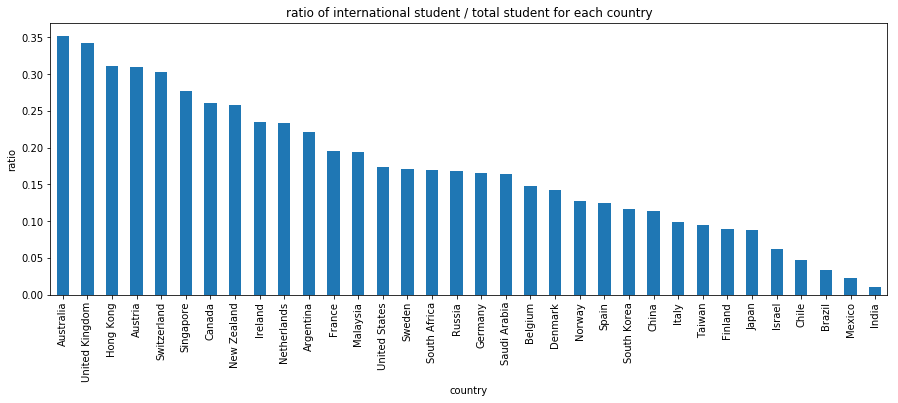

In [18]:
data_1c_22 = data_1b.groupby('country')['international_student'].sum().div(data_1b.groupby('country')['total_student'].sum()).sort_values(ascending=False)
ax = data_1c_22.plot.bar(y="ratio_faculty_student", figsize=(15, 5), title="ratio of international student / total student for each country" )
ax.set_ylabel("ratio")
plt.show()

According to results Australia and United Kingdom has the highest two ratios in terms of international students. Observing the bar plots, one can see that ratio of international students dramatically change as we go to the right in the x axis. Generally developed countries that also take relatively more immigrants have the higher international student ratio whereas last 4 places have occupied by developing countries. 

# 1.d

Use the DataFrame in 1.a, group the data by region and take the mean of ratio_faculty_student column. The approach below takes the mean of ratios of all universities in the region for each region, instead of finding the total number of faculty and student in the region and then taking the ratio. The results are then showed using bar plot.

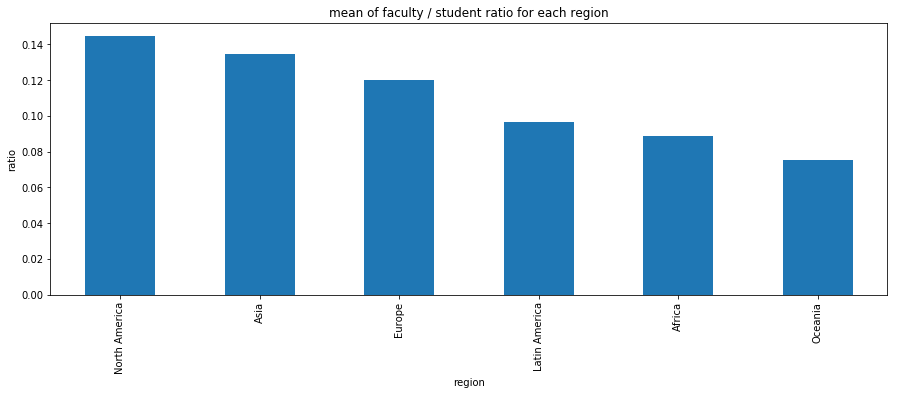

In [19]:
data_1d_1 = data_1a.groupby("region").agg("mean").sort_values("ratio_faculty_student", ascending=False)["ratio_faculty_student"]
ax = data_1d_1.plot.bar(y="ratio_faculty_student", figsize=(15, 5), title="mean of faculty / student ratio for each region" )
ax.set_ylabel("ratio")
plt.show()

Use the DataFrame in 1.a, group the data by region and take the ratio of sum of total_faculty and total_student. The approach below finds the total number of international student and total student in the region and then takes their ratio. The results are then showed using bar plot.

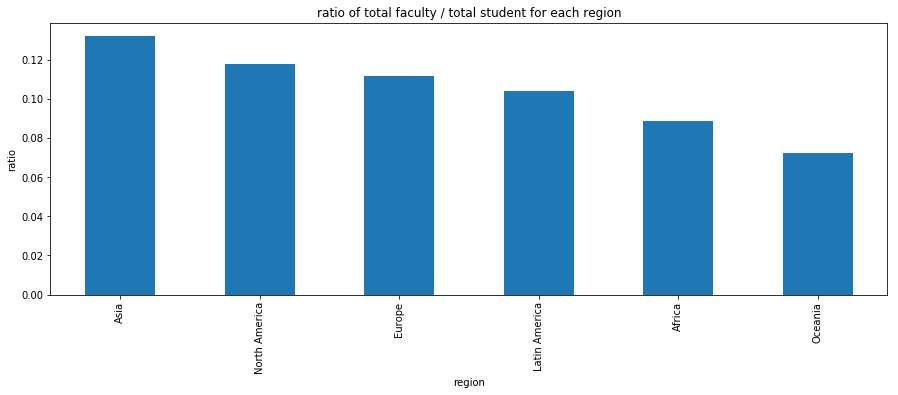

In [20]:
data_1d_11 = data_1a.groupby('region')['total_faculty'].sum().div(data_1a.groupby('region')['total_student'].sum()).sort_values(ascending=False)
ax = data_1d_11.plot.bar(y="ratio_faculty_student", figsize=(15, 5), title="ratio of total faculty / total student for each region" )
ax.set_ylabel("ratio")
plt.show()

According to results different regions have very different values for faculty to student ratio. The underlying reason might be the style differences in the lectures. Or depending on the supply and demand relationship for university education, these ratios might differ. 

Use the DataFrame in 1.b, group the data by region and take the mean of ratio_international_student column. The approach below takes the mean of ratios of all universities in the region for each region, instead of finding the total number of international student and total student in the region and then taking the ratio. The results are then showed using bar plot.

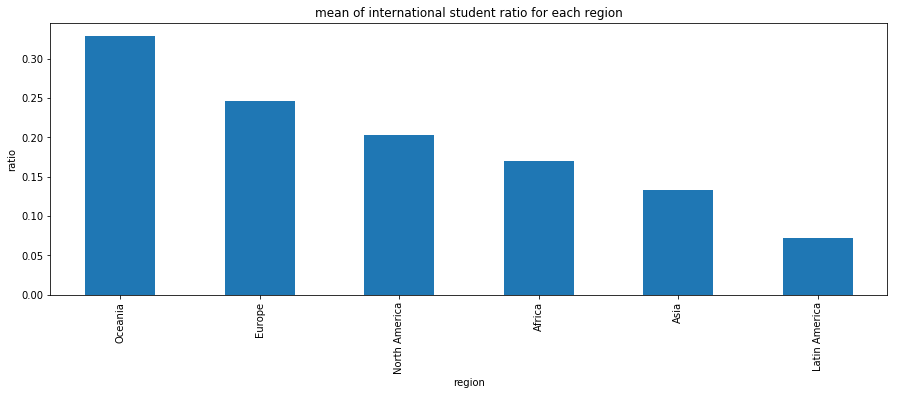

In [21]:
data_1d_2 = data_1b.groupby("region").agg("mean").sort_values("ratio_international_student", ascending=False)["ratio_international_student"]
ax = data_1d_2.plot.bar(y="ratio_international_student", figsize=(15, 5), title="mean of international student ratio for each region" )
ax.set_ylabel("ratio")
plt.show()

Use the DataFrame in 1.b, group the data by region and take the ratio of sum of international_student and total_student. The approach below finds the total number of international student and total student in the region and then takes their ratio. The results are then showed using bar plot.

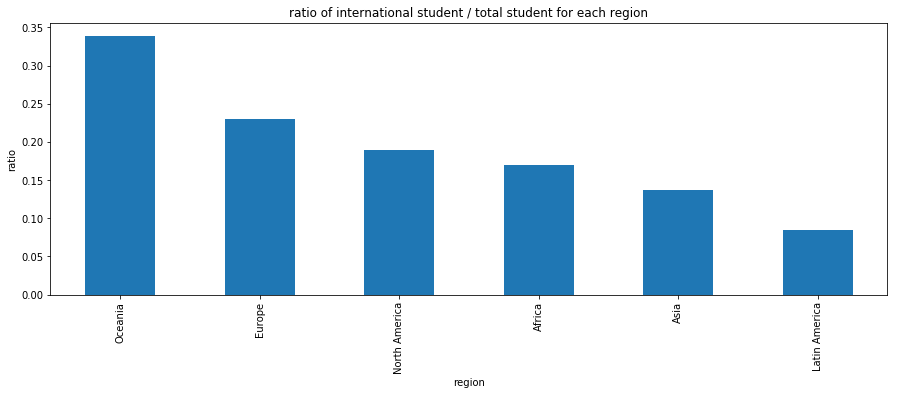

In [22]:
data_1d_22 = data_1b.groupby('region')['international_student'].sum().div(data_1b.groupby('region')['total_student'].sum()).sort_values(ascending=False)
ax = data_1d_22.plot.bar(y="ratio_faculty_student", figsize=(15, 5), title="ratio of international student / total student for each region" )
ax.set_ylabel("ratio")
plt.show()

Different regions have dramatically different ratios of international students. The ranking resembles ranking for ratio of immigrant populations as well, which makes sense intuitively. If immigrant ratio is high, ratio of international students should also be high. Also, regions with developed countries have higher ratio of international students which is again reasonable. Because people tend to go to the developed countries to get better education instead of studying at their local universities.

# 2

The second website is given with url "http://timeshighereducation.com/world-university-rankings/2018/world-ranking". This is the main page for 2018 rankings and by default displays top 25 universities. Examining the HTML page served by the server, one cannot see university specific information given on the source code. Using postman (or any other tool with similar functionality) one can examine requests sent to the server and answers sent by the server. These answers include other file formats as well (i.e. images, stylesheets, scripts). Examining the answer of the server for the GET request with url of ranking, one can see that the server returns "https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json" file as well. Clicking the link and observing the structure of the data, one can see that it is a JSON file with names and features of the universities.

The code below sends request to get that JSON file using requests library. The text contained in the JSON is set to variable json2_text, and then using pandas functionality the first part of the JSON which contains data for universities (json2_text["data"]) is loaded to DataFrame for first num_of_rank = 200 universities.

In [23]:
json2_url = "https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json"
r = requests.get(json2_url)
json2_text = r.json()
num_of_rank = 200
data2 = pd.DataFrame(data=json2_text["data"][0:num_of_rank], index=list(range(num_of_rank)))
print(data2.columns)

Index(['aliases', 'location', 'member_level', 'name', 'nid', 'rank',
       'rank_order', 'record_type', 'scores_citations',
       'scores_citations_rank', 'scores_industry_income',
       'scores_industry_income_rank', 'scores_international_outlook',
       'scores_international_outlook_rank', 'scores_overall',
       'scores_overall_rank', 'scores_research', 'scores_research_rank',
       'scores_teaching', 'scores_teaching_rank', 'stats_female_male_ratio',
       'stats_number_students', 'stats_pc_intl_students',
       'stats_student_staff_ratio', 'subjects_offered', 'url'],
      dtype='object')


The columns of the DataFrame are listed above, the unnecessary columns are dropped, then the head of the DataFrame is displayed.

In [24]:
data2.drop(['aliases', 'member_level', 'nid', 'rank_order', 'record_type', 'scores_citations_rank', 'scores_citations_rank', 'scores_industry_income_rank',
       'scores_international_outlook_rank', 'scores_overall_rank', 'scores_research_rank', 'scores_teaching_rank', 'stats_female_male_ratio', 'subjects_offered', 'url'], axis=1, inplace=True)

In [25]:
data2.head(10)

,location,name,rank,scores_citations,scores_industry_income,scores_international_outlook,scores_overall,scores_research,scores_teaching,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio
0,United Kingdom,University of Oxford,1,99.1,63.7,95.0,94.3,99.5,86.7,"20,409",38%,11.2
1,United Kingdom,University of Cambridge,2,97.5,51.5,93.0,93.2,97.8,87.8,"18,389",35%,10.9
2,United States,California Institute of Technology,=3,99.5,92.6,59.7,93.0,97.5,90.3,"2,209",27%,6.5
3,United States,Stanford University,=3,99.9,60.5,77.6,93.0,96.7,89.1,"15,845",22%,7.5
4,United States,Massachusetts Institute of Technology,5,100.0,88.4,87.6,92.5,91.9,87.3,"11,177",34%,8.7
5,United States,Harvard University,6,99.7,46.4,79.7,91.8,98.4,84.2,"20,326",26%,8.9
6,United States,Princeton University,7,99.6,58.0,78.7,91.1,93.9,85.7,"7,955",24%,8.3
7,United Kingdom,Imperial College London,8,96.7,71.6,96.6,89.2,88.7,81.7,"15,857",55%,11.4
8,United States,University of Chicago,9,99.4,39.8,69.6,88.6,90.1,85.3,"13,525",25%,6.2
9,Switzerland,ETH Zurich – Swiss Federal Institute of Techno...,=10,94.3,60.3,98.1,87.7,92.0,76.4,"19,233",38%,14.6


Shape of the DataFrame is (200, 12), 200 universities with 12 fields for each university.

In [26]:
print(data2.shape)

(200, 12)


As one can see from the above DataFrame, it consists of all the information we want. Unlike the first website there is no need to send a separate request for each information and the scrap the necessary information from the HTML source.

However, some cleaning and transformation for the DataFrame needs to be done. Column rank has non-digit characters (such as "=") which symbolizes the case of tie, these are unnecessary. Also columns stats_number_students has non-digit characters (such as ","), remove these as well. Column stats_pc_intl_students has ratio of international students as percentage, take the digits before % sign, convert these characters to ratio. After transforming 3 of these columns, apply to_numeric method to all of the columns.

Using ratio_of_international_students and stats_number_students find international_student, round the number to make integer. Using stats_number_students and stats_student_staff_ratio find total_faculty, round the number to make integer. Change some of the column names (location -> country, title -> name, stats_number_students -> total_student). Drop unnecessary columns (stats_pc_intl_students, stats_student_staff_ratio, ratio_of_international_students). After all, apply to_numeric method to all of the columns.

Region column is missing in the second website. Using the data1 from the first website, make a dictionary named country_to_region which has key as country and value as region. Examining which countries are not contained in the keys of country_to_region, one can see that "Luxembourg" and "Russian Federation" are missing. Add these two to the dictionary by hand. Using apply method with country information of the data2 and country_to_region, region column is added to data2 as well.

Columns are ordered.

After all, data from the second website is ready to use in data analysis.

In [27]:
data2["stats_number_students"] = data2["stats_number_students"].apply(lambda x: re.sub("[^0-9]", "", x))
data2["rank"] = data2["rank"].apply(lambda x: re.sub("[^0-9]", "", x))
data2["ratio_of_international_students"] = data2["stats_pc_intl_students"].apply(lambda x: float(x[:-1])/100)
data2 = data2.apply(pd.to_numeric, errors="ignore")
data2["international_student"] = (data2["ratio_of_international_students"] * data2["stats_number_students"]).round()
data2["total_faculty"] = (data2["stats_number_students"] / data2["stats_student_staff_ratio"]).round()
data2.rename(columns={'location': 'country', 'title': 'name', 'stats_number_students': 'total_student', "scores_overall":"score"}, inplace=True)
data2.drop(["stats_pc_intl_students", "stats_student_staff_ratio", "ratio_of_international_students"], axis=1, inplace=True)
data2 = data2.apply(pd.to_numeric, errors="ignore")

country_to_region = data1[["country", "region"]].set_index("country").to_dict()["region"]
country_to_region["Luxembourg"] = "Europe"
country_to_region["Russian Federation"] = "Europe"

data2["region"] = data2["country"].apply(lambda x: country_to_region[x])

data2 = data2[["name", "country", "region", "rank", "score", "total_faculty", "international_student", "total_student", 'scores_citations', 'scores_industry_income', 'scores_international_outlook', 'scores_research', 'scores_teaching']]

In [28]:
data2

,name,country,region,rank,score,total_faculty,international_student,total_student,scores_citations,scores_industry_income,scores_international_outlook,scores_research,scores_teaching
0,University of Oxford,United Kingdom,Europe,1,94.3,1822.0,7755.0,20409,99.1,63.7,95.0,99.5,86.7
1,University of Cambridge,United Kingdom,Europe,2,93.2,1687.0,6436.0,18389,97.5,51.5,93.0,97.8,87.8
2,California Institute of Technology,United States,North America,3,93.0,340.0,596.0,2209,99.5,92.6,59.7,97.5,90.3
3,Stanford University,United States,North America,3,93.0,2113.0,3486.0,15845,99.9,60.5,77.6,96.7,89.1
4,Massachusetts Institute of Technology,United States,North America,5,92.5,1285.0,3800.0,11177,100.0,88.4,87.6,91.9,87.3
5,Harvard University,United States,North America,6,91.8,2284.0,5285.0,20326,99.7,46.4,79.7,98.4,84.2
6,Princeton University,United States,North America,7,91.1,958.0,1909.0,7955,99.6,58.0,78.7,93.9,85.7
7,Imperial College London,United Kingdom,Europe,8,89.2,1391.0,8721.0,15857,96.7,71.6,96.6,88.7,81.7
8,University of Chicago,United States,North America,9,88.6,2181.0,3381.0,13525,99.4,39.8,69.6,90.1,85.3
9,ETH Zurich – Swiss Federal Institute of Techno...,Switzerland,Europe,10,87.7,1317.0,7309.0,19233,94.3,60.3,98.1,92.0,76.4


# 2.a

Copy the DataFrame for the data in the second website and add new column for ratio of total_faculty to total_student. Sort the DataFrame with respect to ratio_faculty_student and then display the DataFrame for top 20 university with some of the columns.

In [29]:
data_2a = data2.copy()
data_2a["ratio_faculty_student"] = data_2a["total_faculty"] / data_2a["total_student"]
data_2a.sort_values("ratio_faculty_student", ascending=False, inplace=True)

In [30]:
data_2a[["rank", "country", "region", "name", "ratio_faculty_student"]].head(20)

,rank,country,region,name,ratio_faculty_student
105,105,United States,North America,Vanderbilt University,0.303056
109,109,Denmark,Europe,University of Copenhagen,0.243889
11,12,United States,North America,Yale University,0.232579
153,153,United States,North America,University of Rochester,0.232565
12,13,United States,North America,Johns Hopkins University,0.232546
97,98,United States,North America,Emory University,0.227291
16,17,United States,North America,Duke University,0.222208
114,115,France,Europe,École Polytechnique,0.196141
183,184,Italy,Europe,Scuola Normale Superiore di Pisa,0.192233
101,100,United States,North America,University of Pittsburgh,0.169492


According to results, universities with high ratio of faculty to student can be ranked in any place, ranks are dispersed for such universities. There are differences between the data of the first and second websites although there are some universities (Yale University and John Hopkins) with high ratio in the both data. These differences are the result of methodology, more specificially the exact meaning and scope of the faculty.

# 2.b

Copy the DataFrame for the data in the second website and add new column ratio_international_student for ratio of international student to total_student. Sort the DataFrame with respect to ratio_international_student and then display the DataFrame for top 20 university with some of the columns.

In [31]:
data_2b = data2.copy()
data_2b["ratio_international_student"] = data_2b["international_student"] / data_2b["total_student"]
data_2b.sort_values("ratio_international_student", ascending=False, inplace=True)

In [32]:
data_2b[["rank", "country", "region", "name", "ratio_international_student"]].head(20)

,rank,country,region,name,ratio_international_student
24,25,United Kingdom,Europe,London School of Economics and Political Science,0.709985
178,179,Luxembourg,Europe,University of Luxembourg,0.569934
7,8,United Kingdom,Europe,Imperial College London,0.549978
37,38,Switzerland,Europe,École Polytechnique Fédérale de Lausanne,0.549960
102,103,Netherlands,Europe,Maastricht University,0.500030
15,16,United Kingdom,Europe,University College London,0.490001
143,143,United Kingdom,Europe,University of St Andrews,0.479956
23,24,United States,North America,Carnegie Mellon University,0.449984
120,121,United Kingdom,Europe,Queen Mary University of London,0.449984
39,40,Hong Kong,Asia,University of Hong Kong,0.420007


The differences between the two data from different websites are very subtle. These differences are the result of two lists not containing the exactly same universities. For example in the results above University of Luxembourg is ranked 2, whereas in the first website it is not even contained in the data as it is not placed in the top 200 universities. Other than such differences, both university rankings and ratios are consistent. Similar to the results from the first website, having high ratio of international students does not convey much information about the ranking, if any.

# 2.c

Use the DataFrame in 2.a, group the data by country and take the mean of ratio_faculty_student column. The approach below takes the mean of ratios of all universities in the country for each country, instead of finding the total number of faculty and student in the country and then taking the ratio. The results are then showed using bar plot.

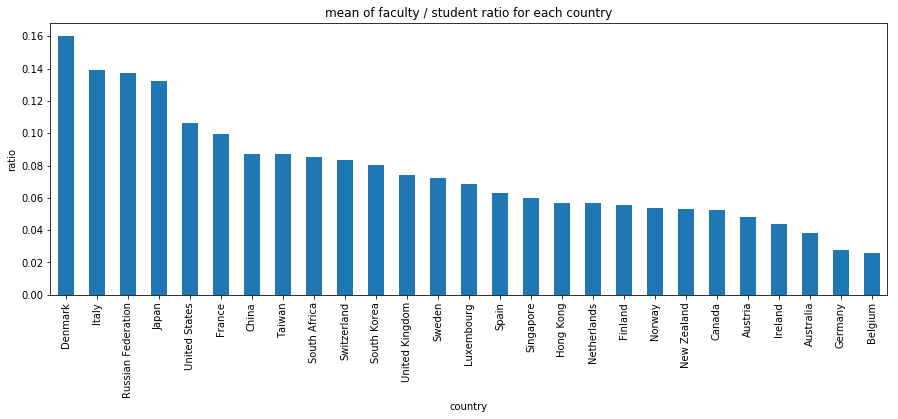

In [33]:
data_2c_1 = data_2a.groupby("country").agg("mean").sort_values("ratio_faculty_student", ascending=False)["ratio_faculty_student"]
ax = data_2c_1.plot.bar(y="ratio_faculty_student", figsize=(15, 5), title="mean of faculty / student ratio for each country" )
ax.set_ylabel("ratio")
plt.show()

Use the DataFrame in 2.a, group the data by country and take the ratio of sum of total_faculty and total_student. The approach below finds the total number of international student and total student in the country and then takes their ratio. The results are then showed using bar plot.

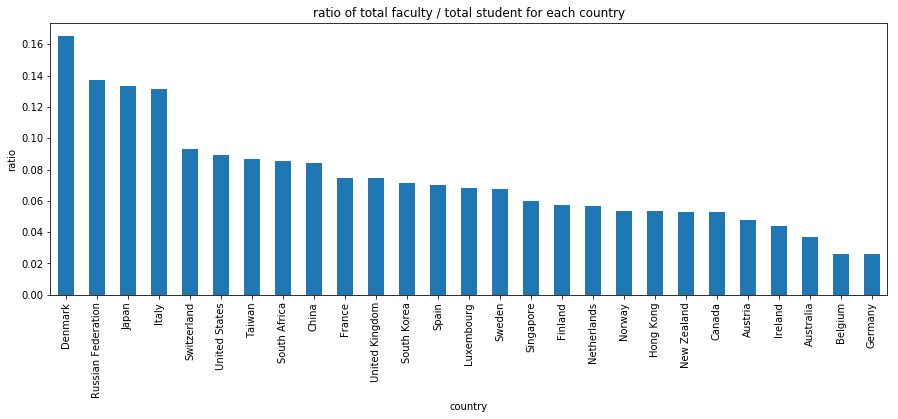

In [34]:
data_2c_11 = data_2a.groupby('country')['total_faculty'].sum().div(data_2a.groupby('country')['total_student'].sum()).sort_values(ascending=False)
ax = data_2c_11.plot.bar(y="ratio_faculty_student", figsize=(15, 5), title="ratio of total faculty / total student for each country" )
ax.set_ylabel("ratio")
plt.show()

According to results, Russia has the highest ratio of faculty to student. Denmark follows Russia and then Japan comes third. The United States and most of the European countries are relatively low ratio of faculty to student. The underlying reason might be the different styles of lectures. Note that results are slightly different than the results from the first website. The reason might be about the exact definiton and scope of faculty position.

Use the DataFrame in 2.b, group the data by country and take the mean of ratio_international_student column. The approach below takes the mean of ratios of all universities in the country for each country, instead of finding the total number of international student and total student in the country and then taking the ratio. The results are then showed using bar plot.

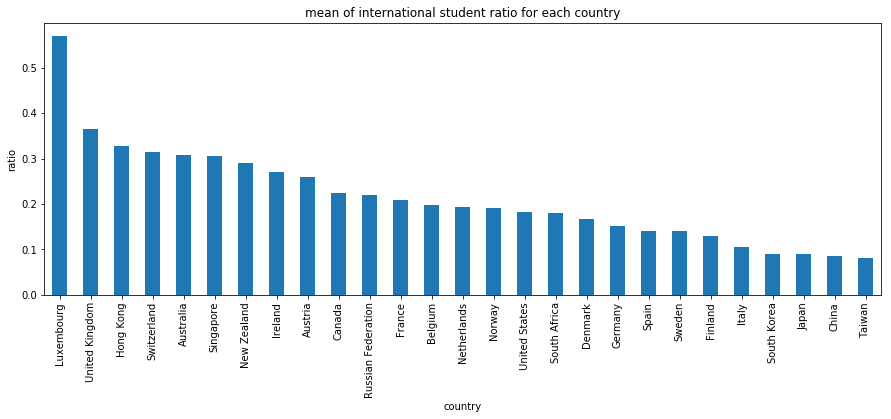

In [35]:
data_2c_2 = data_2b.groupby("country").agg("mean").sort_values("ratio_international_student", ascending=False)["ratio_international_student"]
ax = data_2c_2.plot.bar(y="ratio_international_student", figsize=(15, 5), title="mean of international student ratio for each country" )
ax.set_ylabel("ratio")
plt.show()

Use the DataFrame in 2.b, group the data by country and take the ratio of sum of international_student and total_student. The approach below finds the total number of international student and total student in the country and then takes their ratio. The results are then showed using bar plot.

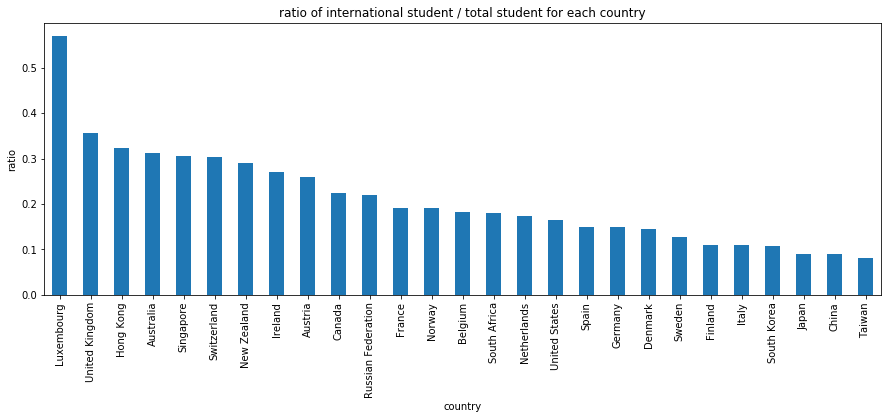

In [36]:
data_2c_22 = data_2b.groupby('country')['international_student'].sum().div(data_2b.groupby('country')['total_student'].sum()).sort_values(ascending=False)
ax = data_2c_22.plot.bar(y="ratio_faculty_student", figsize=(15, 5), title="ratio of international student / total student for each country" )
ax.set_ylabel("ratio")
plt.show()

According to results Luxembourg has very high ratio of international students. This is sensible as Luxembourg is very small in population and size, and also very close to the lots of relatively bigger and populous countries. Observing the bar plots, one can see that ratio of international students dramatically change as we go to the right in the x axis. Generally developed countries that also take relatively more immigrants have the higher international student ratio whereas last 4 places are the countries which are not known for their incoming foreigner students.

# 2.d

Use the DataFrame in 2.a, group the data by region and take the mean of ratio_faculty_student column. The approach below takes the mean of ratios of all universities in the region for each region, instead of finding the total number of faculty and student in the region and then taking the ratio. The results are then showed using bar plot.

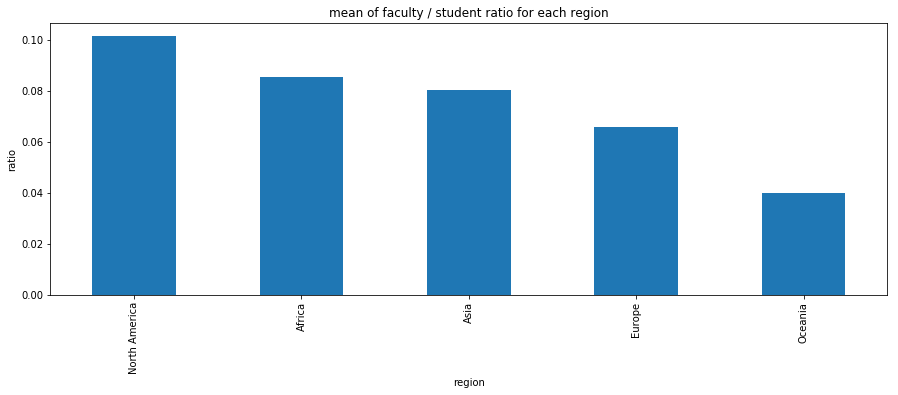

In [37]:
data_2d_1 = data_2a.groupby("region").agg("mean").sort_values("ratio_faculty_student", ascending=False)["ratio_faculty_student"]
ax = data_2d_1.plot.bar(y="ratio_faculty_student", figsize=(15, 5), title="mean of faculty / student ratio for each region" )
ax.set_ylabel("ratio")
plt.show()

Use the DataFrame in 2.a, group the data by region and take the ratio of sum of total_faculty and total_student. The approach below finds the total number of international student and total student in the region and then takes their ratio. The results are then showed using bar plot.

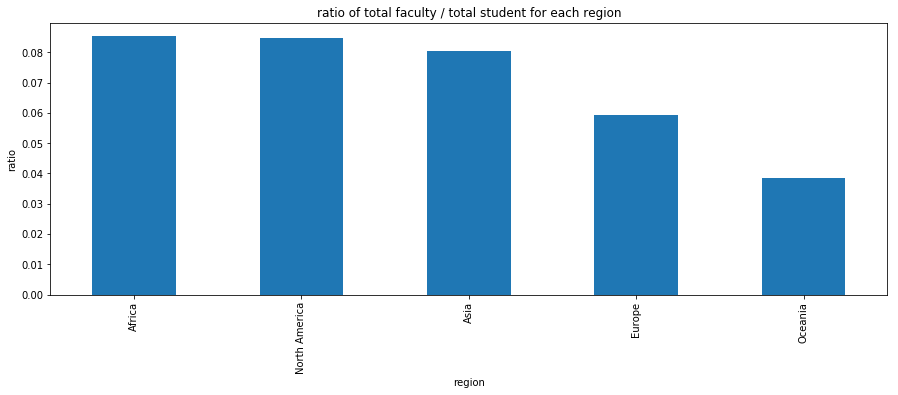

In [38]:
data_2d_11 = data_2a.groupby('region')['total_faculty'].sum().div(data_2a.groupby('region')['total_student'].sum()).sort_values(ascending=False)
ax = data_2d_11.plot.bar(y="ratio_faculty_student", figsize=(15, 5), title="ratio of total faculty / total student for each region" )
ax.set_ylabel("ratio")
plt.show()

According to results different regions have very different values for faculty to student ratio. The underlying reason might be the style differences in the lectures. Or depending on the supply and demand relationship for university education, these ratios might differ. The results are very different from the results from the first website. The reason might be about the exact definition and scope of faculty position. Also note that, unlike in the results from the first website the Latin America is not contained in these results as they do not have any university in top 200.

Use the DataFrame in 2.b, group the data by region and take the mean of ratio_international_student column. The approach below takes the mean of ratios of all universities in the region for each region, instead of finding the total number of international student and total student in the region and then taking the ratio. The results are then showed using bar plot.

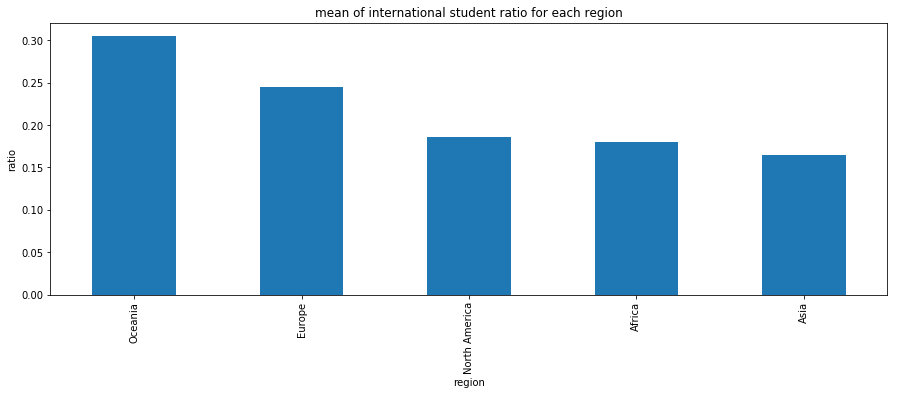

In [39]:
data_2d_2 = data_2b.groupby("region").agg("mean").sort_values("ratio_international_student", ascending=False)["ratio_international_student"]
ax = data_2d_2.plot.bar(y="ratio_international_student", figsize=(15, 5), title="mean of international student ratio for each region" )
ax.set_ylabel("ratio")
plt.show()

Use the DataFrame in 2.b, group the data by region and take the ratio of sum of international_student and total_student. The approach below finds the total number of international student and total student in the region and then takes their ratio. The results are then showed using bar plot.

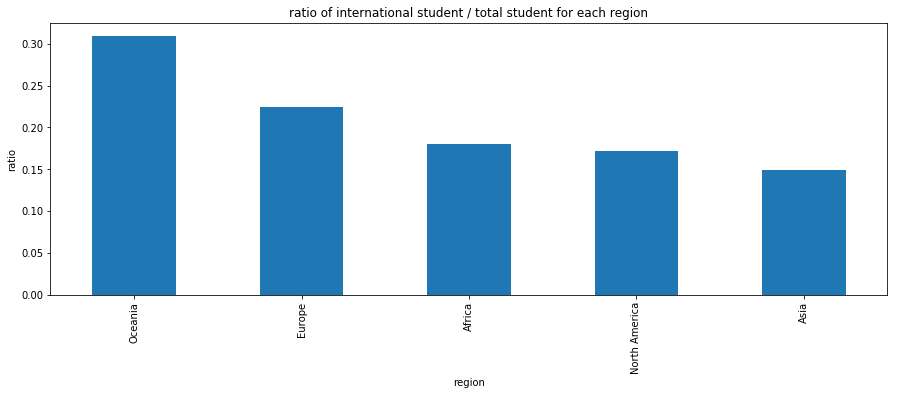

In [40]:
data_2d_22 = data_2b.groupby('region')['international_student'].sum().div(data_2b.groupby('region')['total_student'].sum()).sort_values(ascending=False)
ax = data_2d_22.plot.bar(y="ratio_faculty_student", figsize=(15, 5), title="ratio of international student / total student for each region" )
ax.set_ylabel("ratio")
plt.show()

Different regions have dramatically different ratios of international students. The ranking resembles ranking for ratio of immigrant populations as well, which makes sense intuitively. If immigrant ratio is high, ratio of international students should also be high. Also, regions with developed countries have higher ratio of international students which is again reasonable. Because people tend to go to the developed countries to get better education instead of studying at their local universities. The only subtle difference with the results from the first website is higher international student ratio for Africa in the data. That might be as a result of differences in the raw data, or different African universities which are in top 200.

# 3

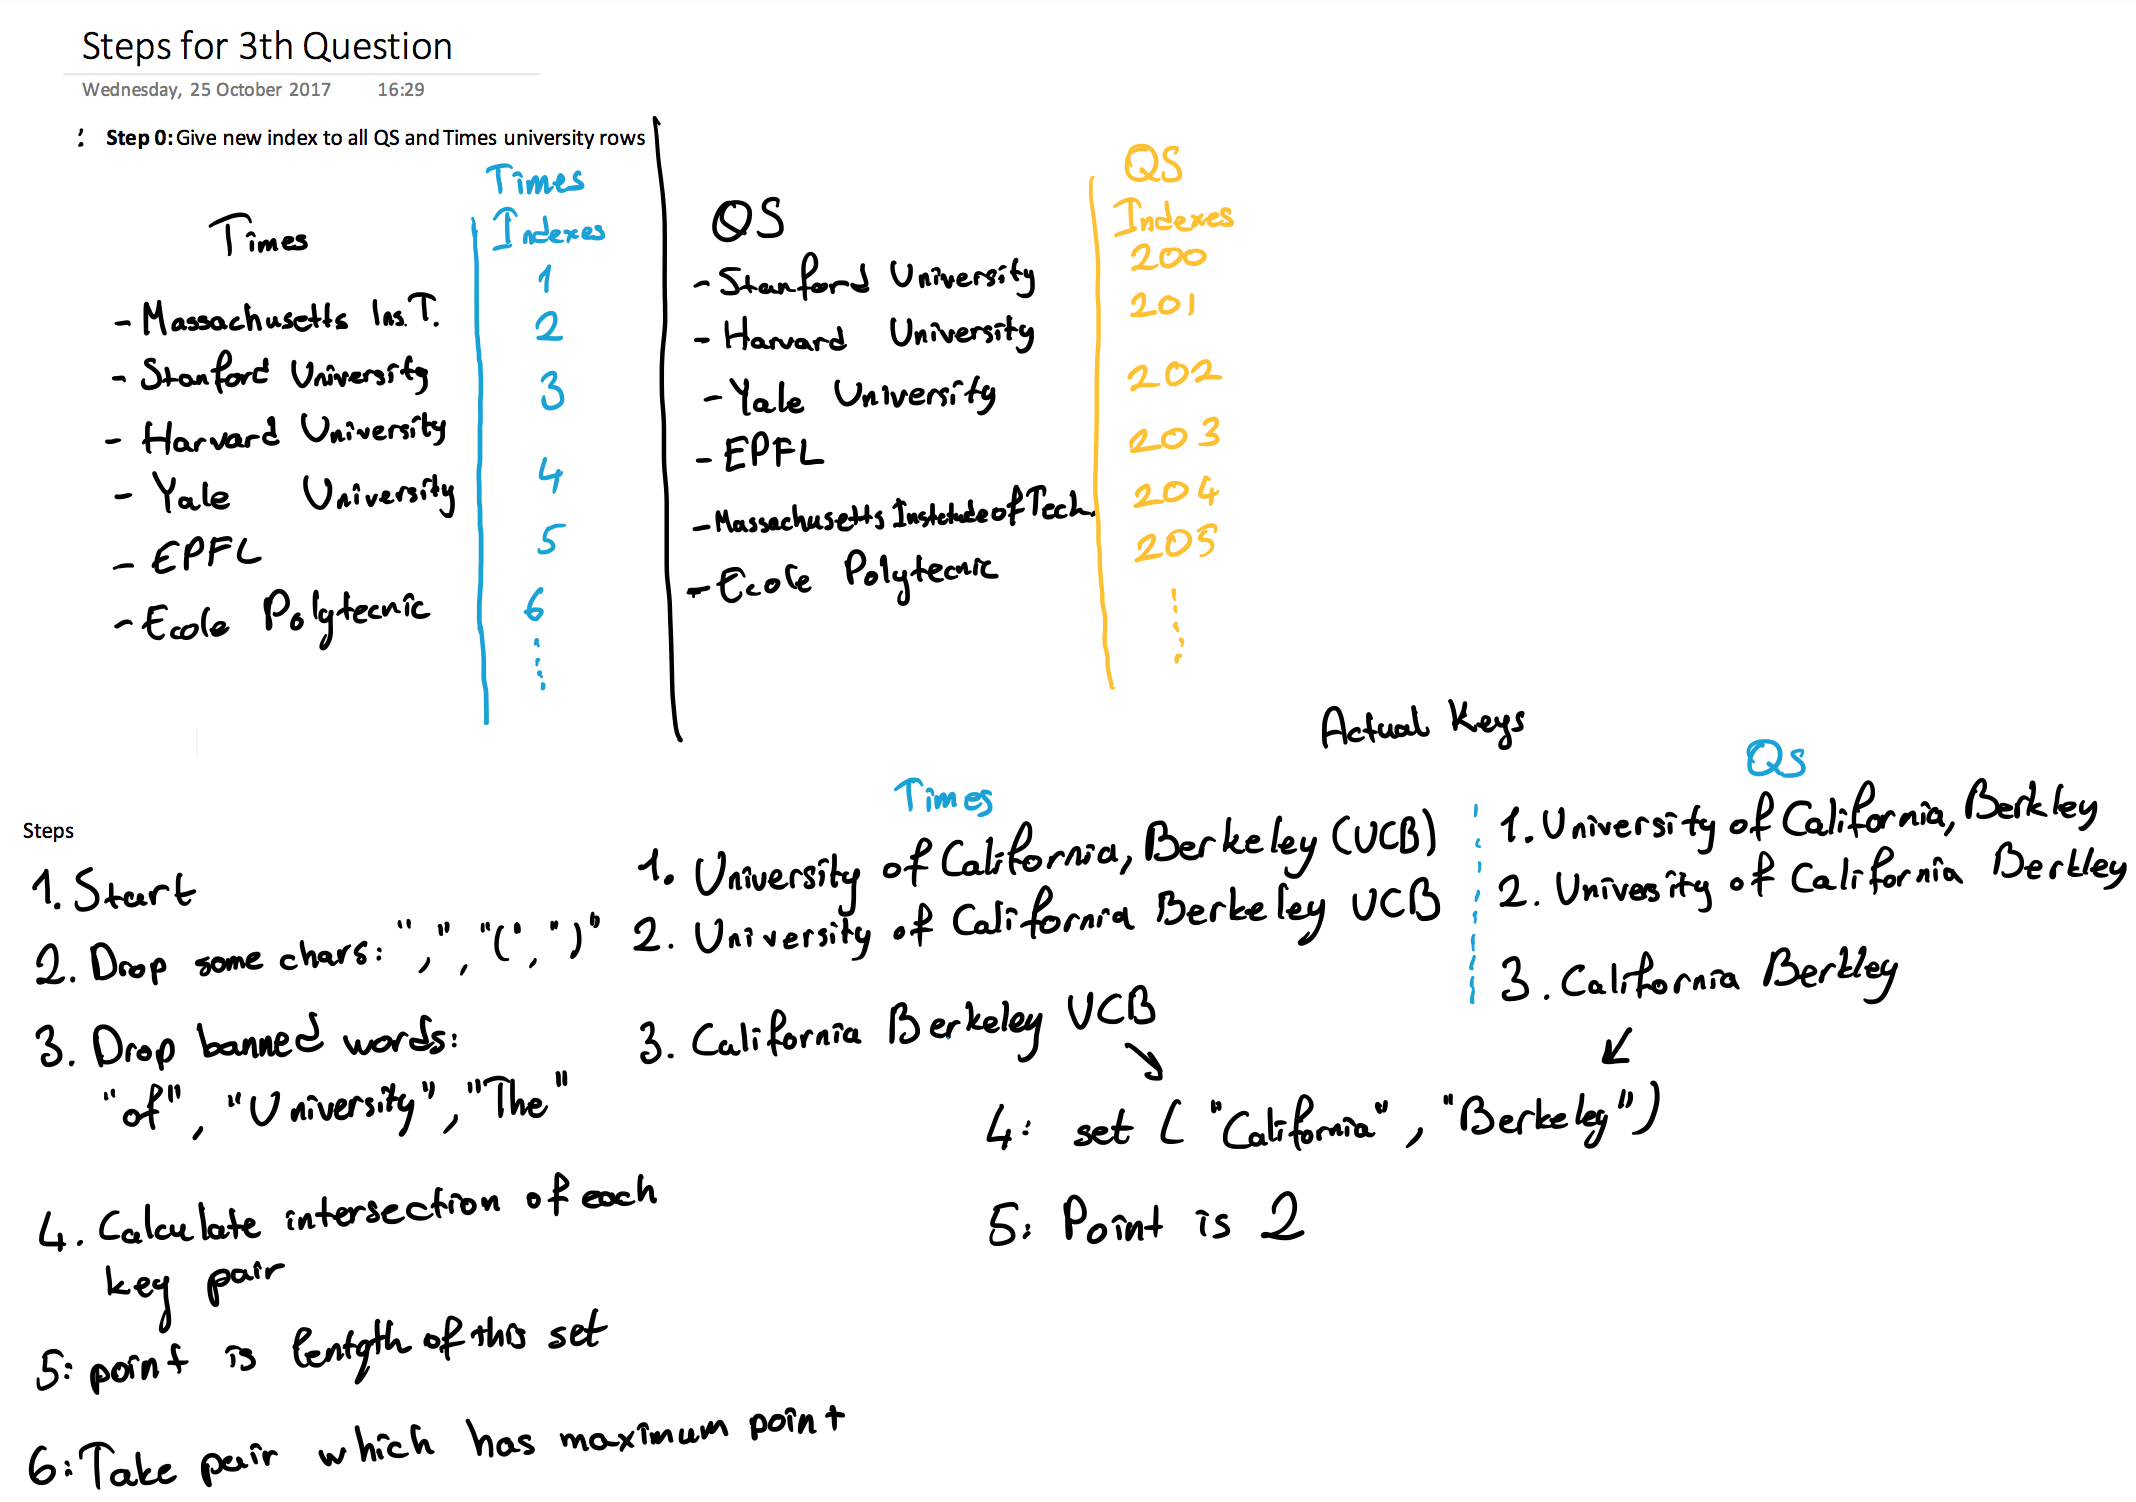

Copy DataFrames to not change the original DataFrames. Rename columns such that _QS is added to the end of each column of QS DataFrame and _Times is added to the end of each column of Times DataFrame. 

In [41]:
QS = data1.copy()
QS.rename(columns=lambda x: x + "_QS", inplace=True)
Times = data2.copy()
Times.rename(columns=lambda x: x + "_Times", inplace=True)

Find the closest elements in name columns in both DataFrames and match them using nameIndex column.

In [42]:
banned = set(['University', 'of', 'The']) # Banned, useless words

# Extract paranthesis
# Divide words
# Substract banned words
# to list

QS_words = QS['name_QS'].apply(lambda x: [x.replace(')', '').replace('(','') for x in x.split(' ')]).apply(lambda x: list(set(x) - banned)).tolist()
Times_words = Times['name_Times'].apply(lambda x: [x.replace(')', '').replace('(','') for x in x.split(' ')]).apply(lambda x: list(set(x) - banned)).tolist()

# points are from the same words
points = [[len(set(qs_word_list) & set(times_word_list)) for qs_word_list in QS_words] for times_word_list in Times_words]

times_ids = [i for i in range(200)] # suppose every name from Times are different
qs_ids = [i for i in range(200,400)] # suppose every name from QS are differetent

used_names = []

points = [[len(set(qs_word_list) & set(times_word_list)) for qs_word_list in QS_words] for times_word_list in Times_words]
for idx, point in enumerate(points):
    indices = [i for i, x in enumerate(point) if x == max(point)] # Find maximum points
    for index in indices:
        if index not in used_names:
            if max(point) > 0:
                used_names.append(index)
                qs_ids[index] = idx
            break
        
Times['nameIndex'] = times_ids
QS['nameIndex'] = qs_ids

Merge Times and QS DataFrames using outer join (there are elements in both DataFrames which do not have equivalent in the other DataFrame, the only way to not lose the data is to use outer join) on nameIndex column of both DataFrames. Then drop that column.

In [43]:
result = pd.merge(QS, Times, how='outer', on=['nameIndex'])
result.drop(["nameIndex"], axis=1, inplace=True)

Resulting columns of result DataFrame which is the merger of the data from the 2 websites.

In [44]:
result.columns

Index(['name_QS', 'country_QS', 'region_QS', 'rank_QS', 'score_QS',
       'international_faculty_QS', 'total_faculty_QS',
       'international_student_QS', 'total_student_QS', 'name_Times',
       'country_Times', 'region_Times', 'rank_Times', 'score_Times',
       'total_faculty_Times', 'international_student_Times',
       'total_student_Times', 'scores_citations_Times',
       'scores_industry_income_Times', 'scores_international_outlook_Times',
       'scores_research_Times', 'scores_teaching_Times'],
      dtype='object')

In [45]:
result.head(20)

,name_QS,country_QS,region_QS,rank_QS,score_QS,international_faculty_QS,total_faculty_QS,international_student_QS,total_student_QS,name_Times,...,rank_Times,score_Times,total_faculty_Times,international_student_Times,total_student_Times,scores_citations_Times,scores_industry_income_Times,scores_international_outlook_Times,scores_research_Times,scores_teaching_Times
0,Massachusetts Institute of Technology (MIT),United States,North America,1.0,100.0,1679.0,2982.0,3717.0,11067.0,Massachusetts Institute of Technology,...,5.0,92.5,1285.0,3800.0,11177.0,100.0,88.4,87.6,91.9,87.3
1,Stanford University,United States,North America,2.0,98.7,2042.0,4285.0,3611.0,15878.0,Stanford University,...,3.0,93.0,2113.0,3486.0,15845.0,99.9,60.5,77.6,96.7,89.1
2,Harvard University,United States,North America,3.0,98.4,1311.0,4350.0,5266.0,22429.0,Harvard University,...,6.0,91.8,2284.0,5285.0,20326.0,99.7,46.4,79.7,98.4,84.2
3,California Institute of Technology (Caltech),United States,North America,4.0,97.7,350.0,953.0,647.0,2255.0,California Institute of Technology,...,3.0,93.0,340.0,596.0,2209.0,99.5,92.6,59.7,97.5,90.3
4,University of Cambridge,United Kingdom,Europe,5.0,95.6,2278.0,5490.0,6699.0,18770.0,University of Cambridge,...,2.0,93.2,1687.0,6436.0,18389.0,97.5,51.5,93.0,97.8,87.8
5,University of Oxford,United Kingdom,Europe,6.0,95.3,2964.0,6750.0,7353.0,19720.0,University of Oxford,...,1.0,94.3,1822.0,7755.0,20409.0,99.1,63.7,95.0,99.5,86.7
6,UCL (University College London),United Kingdom,Europe,7.0,94.6,2554.0,6345.0,14854.0,31080.0,University College London,...,16.0,85.3,2886.0,14849.0,30304.0,94.6,41.2,94.6,88.2,74.4
7,Imperial College London,United Kingdom,Europe,8.0,93.7,2071.0,3930.0,8746.0,16090.0,Imperial College London,...,8.0,89.2,1391.0,8721.0,15857.0,96.7,71.6,96.6,88.7,81.7
8,University of Chicago,United States,North America,9.0,93.5,635.0,2449.0,3379.0,13557.0,University of Chicago,...,9.0,88.6,2181.0,3381.0,13525.0,99.4,39.8,69.6,90.1,85.3
9,ETH Zurich - Swiss Federal Institute of Techno...,Switzerland,Europe,10.0,93.3,1886.0,2477.0,7563.0,19815.0,ETH Zurich – Swiss Federal Institute of Techno...,...,10.0,87.7,1317.0,7309.0,19233.0,94.3,60.3,98.1,92.0,76.4


Use multi level column labels QS and Times.

In [46]:
result_multi_level_column = result.copy()
columns=[('QS', x[:-3]) if x[-2:]=="QS" else ('Times', x[:-6]) for x in result.columns]
result_multi_level_column.columns=pd.MultiIndex.from_tuples(columns)

In [47]:
result_multi_level_column.head(20)

QS                  \
                                                 name         country   
0         Massachusetts Institute of Technology (MIT)   United States   
1                                 Stanford University   United States   
2                                  Harvard University   United States   
3        California Institute of Technology (Caltech)   United States   
4                             University of Cambridge  United Kingdom   
5                                University of Oxford  United Kingdom   
6                     UCL (University College London)  United Kingdom   
7                             Imperial College London  United Kingdom   
8                               University of Chicago   United States   
9   ETH Zurich - Swiss Federal Institute of Techno...     Switzerland   
10  Nanyang Technological University, Singapore (NTU)       Singapore   
11    Ecole Polytechnique Fédérale de Lausanne (EPFL)     Switzerland   
12                               Princeton University   United States   
13                                 Cornell University   United States   
14             National University of Singapore (NUS)       Singapore   
15                                    Yale University   United States   
16                           Johns Hopkins University   United States   
17                                Columbia University   United States   
18                         University of Pennsylvania   United States   
19                 The Australian National University       Australia   

                                                                    \
           region  rank  score international_faculty total_faculty   
0   North America   1.0  100.0                1679.0        2982.0   
1   North America   2.0   98.7                2042.0        4285.0   
2   North America   3.0   98.4                1311.0        4350.0   
3   North America   4.0   97.7                 350.0         953.0   
4          Europe   5.0   95.6                2278.0        5490.0   
5          Europe   6.0   95.3                2964.0        6750.0   
6          Europe   7.0   94.6                2554.0        6345.0   
7          Europe   8.0   93.7                2071.0        3930.0   
8   North America   9.0   93.5                 635.0        2449.0   
9          Europe  10.0   93.3                1886.0        2477.0   
10           Asia  11.0   92.2                2993.0        4338.0   
11         Europe  12.0   91.2                1300.0        1695.0   
12  North America  13.0   91.0                 246.0        1007.0   
13  North America  14.0   90.7                 970.0        2718.0   
14           Asia  15.0   90.5                3086.0        5106.0   
15  North America  16.0   90.4                1708.0        4940.0   
16  North America  17.0   89.8                1061.0        4462.0   
17  North America  18.0   88.9                 913.0        6189.0   
18  North America  19.0   88.7                1383.0        5499.0   
19        Oceania  20.0   87.1                 927.0        1600.0   

                                        \
   international_student total_student   
0                 3717.0       11067.0   
1                 3611.0       15878.0   
2                 5266.0       22429.0   
3                  647.0        2255.0   
4                 6699.0       18770.0   
5                 7353.0       19720.0   
6                14854.0       31080.0   
7                 8746.0       16090.0   
8                 3379.0       13557.0   
9                 7563.0       19815.0   
10                7251.0       25738.0   
11                5896.0       10343.0   
12                1793.0        8069.0   
13                5411.0       21904.0   
14                8917.0       32728.0   
15                2469.0       12402.0   
16                4105.0       16146.0   
17                8105.0       25045.0   
18                4250.0       20639.0   
19                555

After all two DataFrames containing the university ranking data from two different websites are merged on the name, where the strategy used for matching the names is explained above. Note that we did not do any matching for university names by hand. 

# 4

Copy the merged DataFrame. Use corr method of the pandas to find correlation coefficient between any two columns. Note that correlation takes value between -1 and 1 and having a greater magnitude means these two columns are correlated strongly. Correlation being positive means two columns increase and decrease together whereas negative correlation means one is increasing means other one is decreasing. Note that correlation method is selected to be "Pearson" as we want to examine the linear relationships between column pairs.

In [48]:
data_4 = result_multi_level_column.copy()
data_4.corr(method = 'pearson', min_periods=1)

QS                                  \
                                        rank     score international_faculty   
QS    rank                          1.000000 -0.978668             -0.534572   
      score                        -0.978668  1.000000              0.559304   
      international_faculty        -0.534572  0.559304              1.000000   
      total_faculty                -0.316445  0.303872              0.590219   
      international_student        -0.309609  0.287521              0.641201   
      total_student                -0.039802 -0.001817              0.307161   
Times rank                          0.703547 -0.738659             -0.346590   
      score                        -0.756954  0.824176              0.417392   
      total_faculty                -0.267640  0.248297              0.310529   
      international_student        -0.275285  0.259245              0.528737   
      total_student                -0.005994 -0.038393              0.264659   
      scores_citations             -0.222175  0.273839              0.141497   
      scores_industry_income       -0.059806  0.065208             -0.038786   
      scores_international_outlook -0.153541  0.177178              0.410111   
      scores_research              -0.760838  0.813545              0.389841   
      scores_teaching              -0.745585  0.801843              0.338803   

                                                                        \
                                   total_faculty international_student   
QS    rank                             -0.316445             -0.309609   
      score                             0.303872              0.287521   
      international_faculty             0.590219              0.641201   
      total_faculty                     1.000000              0.471808   
      international_student             0.471808              1.000000   
      total_student                     0.764622              0.558612   
Times rank                             -0.352672             -0.221380   
      score                             0.375359              0.198417   
      total_faculty                     0.730849              0.191772   
      international_student             0.380489              0.911561   
      total_student                     0.610581              0.553929   
      scores_citations                  0.075694              0.081100   
      scores_industry_income           -0.056936             -0.152703   
      scores_international_outlook     -0.191425              0.392514   
      scores_research                   0.422113              0.194001   
      scores_teaching                   0.436074              0.096778   

                                                     Times            \
                                   total_student      rank     score   
QS    rank                             -0.039802  0.703547 -0.756954   
      score                            -0.001817 -0.738659  0.824176   
      international_faculty             0.307161 -0.346590  0.417392   
      total_faculty                     0.764622 -0.352672  0.375359   
      international_student             0.558612 -0.221380  0.198417   
      total_student                     1.000000 -0.101484  0.036776   
Times rank                             -0.101484  1.000000 -0.933811   
      score                             0.036776 -0.933811  1.000000   
      total_faculty                     0.521432 -0.248861  0.260048   
      international_student             0.543835 -0.328156  0.292196   
      total_student                     0.952422 -0.151891  0.079852   
      scores_citations                 -0.166634 -0.453522  0.467274   
      scores_industry_income           -0.050991 -0.166704  0.128120   
      scores_international_outlook     -0.260206 -0.101604  0.133871   
      scores_research                   0.174663 -0.874444  0.928402   
      scores_teaching                   0.10

## Examining the correlation values between QS columns only:

rank is almost perfectly correlated with score as expected. Because rank is just ordering of the score and increasing score means decreasing rank (better university). 

rank is strong correlated with international_faculty which means that having high number of international faculty is strong indicator for being a better university.

rank is correlated with total_faculty as well, but the correlation is not that high. Having high number of faculty gives a small clue about being a better university.

rank is only modestly correlated with international_student, whereas there is almost no correlation between rank and total_student.

As score is almost perfectly correlated with rank, the same things can also be said for score as well.

international_faculty is highly correlated with total_faculty. As international_faculty counts in total_faculty as well, increasing international_facult means increasing total_faculty, so the correlation is expected.

international_faculty is also highly correlated with international student. This is also expected because both are related to university being more international. In general, if university has lots of international students it is expected that it also has lots of international faculty and vice versa. So the result is intuitive.

international_faculty is modestly correlated with total_student as well. The reason is international_faculty is highly correlated with international_student which is counted inside total_student, and faculties are there for serving to students and high number of students need high number of faculty.

total_faculty is very highly correlated with total_student. The reason is faculties are there for serving to students and high number of students need high number of faculty.

total_faculty is also correlated with international_student beacuse having more students means needing more faculty.

international_student is correlated with total_students as it is also counted in total_students and having more students directly means having more students as well.

## Examining the correlation values between Times columns only:

rank is almost perfectly correlated with score as expected. Because rank is just ordering of the score and increasing score means decreasing rank (better university). 

rank is only modestly correlated with total_faculty. Having high number of faculty gives a small clue about being a better university.

rank is correlated with international_student, however the correlation is small. Moreover there is almost no correlation between rank and total_student.

ranks has different correlations with scores_citations, scores_industry_income, scores_international_outlook, scores_research and scores_teaching which are auxiliary scores to calculate overall score. Overall score directly specifies rank, as also presented by the almost perfectly correlation between rank and score. Thus, these correlations are almost the same as percentages of these auxiliary scores in the overall score.

As score is almost perfectly correlated with rank, the same things can also be said for score as well.

The correlations between score and scores_citations, scores_industry_income, scores_international_outlook, scores_research, scores_teaching are almost same as percentages of these scored that are added to find overall score, as expected.

total_faculty is modestly correlated with international student. The reason is high number of faculty means high number of students where some of them happen to be international.

total_faculty is very highly correlated with total_student. The reason is faculties are there for serving to students and high number of students need high number of faculty.

total_faculty has mediocre correlation with score_teaching and score_research. These faculties are responsible from teaching and doing research which might explain the correlation.

international_student is correlated with total_students as it is also counted in total_students and having more students directly means having more students as well.

international_student is correlated with scores_international_outlook and the correlation is significant, the reason is whiel calculating the score_international_look number of international students is one of the most important factors.

total_student has no significant correlations with scores_citations, scores_industry_income, scores_international_outlook, scores_research,  scores_teaching.

scores_citations, scores_industry_income, scores_international_outlook, scores_research, scores_teaching have generally insignificant correlation coefficients among themselves. The only exception is correlation between scores_research and scores_teaching which is very high (=0.9). Both are done mainly by faculty and use university facilities. Since underlying needs are the same / similar for both research and teaching the correlation can be explained.

## Examining the correlation values between one QS and one Times column:

rank and score columns of QS have highly significant correlation values with rank and score columns of Times. This is expected as both have the same aim, ranking universities. As a result these two rankings have some overlap and similar patterns in their rankings.

total_faculty, international_student, total_student columns of Times have high correlation values with respective columns in QS rankings. Also any of these 3 columns of Times has significant correlation with the columns in QS that has high correlation with respective columns. For example total_faculty of Times and total_student of QS have significant correlation because both are highly correlated with total_faculty of QS. Other similar correlation examples can be found.

scores_citations, scores_industry_income, scores_international_outlook, scores_research, scores_teaching of Times have similar relations with the columns of QS. If there is a common column in the QS which both are highly correlated, then necessarily these two columns are also correlated. For example, score_research of Times has high correlation with score of Times and score of Times is also highly correlated with score of QS as both aim to do the same thing. Then necessarily score_research of Times have significant correlation with score of QS. Other similar correlation examples can be found.

# 5

Take the copy of the merged DataFrame. 

Drop unnecessary columns 
            ('country_QS', 'region_QS', 'total_faculty_QS', 'international_faculty_QS', 
             'total_student_QS', 'international_student_QS', 'country_Times',
             'total_student_Times', 'international_student_Times', 'total_faculty_Times',
             'region_Times', 'scores_citations_Times', 'scores_industry_income_Times', 'scores_international_outlook_Times',
             'scores_research_Times', 'scores_teaching_Times').

Fill nan's in the name_QS column with name_Times.

Rename and then order columns ("name_QS":"name").
            
Fill nan's such that if it is rank column, it is set to max + 1. The reason is, if a university is not listed in the ranking it is worse than all the other universities in the ranking. Set its ranking such that this is reflected. 
Fill nan's such that if it is score column, it is set to min - 1. The reason is, if a university is not listed in the ranking it is worse than all the other universities in the ranking. Set its score such that this is reflected. 
For both cases there is no order in the universities with nan values as their rankings and scores are set to the same value.

Convert rank_Times and rank_QS columns from float to int.

In [49]:
data_5 = result.copy()

data_5.drop(['country_QS', 'region_QS', 'total_faculty_QS', 'international_faculty_QS', 
             'total_student_QS', 'international_student_QS', 'country_Times',
             'total_student_Times', 'international_student_Times', 'total_faculty_Times',
             'region_Times', 'scores_citations_Times', 'scores_industry_income_Times', 'scores_international_outlook_Times',
             'scores_research_Times', 'scores_teaching_Times'], axis=1, inplace=True)

data_5.name_QS.fillna(data_5.name_Times, inplace=True)
data_5.rename(columns={"name_QS":"name"}, inplace=True)
data_5 = data_5[["name", "rank_QS", "rank_Times", "score_QS", "score_Times"]]

data_5.score_Times.fillna(data_5.score_Times.min()-1, inplace=True)
data_5.rank_Times.fillna(data_5.rank_Times.max()+1, inplace=True)
data_5.score_QS.fillna(data_5.score_QS.min()-1, inplace=True)
data_5.rank_QS.fillna(data_5.rank_QS.max()+1, inplace=True)

data_5.rank_Times = data_5.rank_Times.astype(int)
data_5.rank_QS = data_5.rank_QS.astype(int)

Calculate 5 different "new" ranking features.
* Harmonic mean of rank_QS and rank_Times.
* Harmonic mean of score_QS and score_Times.
* Sum of rank_QS and rank_Times.
* Sum of score_QS and score_Times.
* Summation of Z values for score_QS and score_Times.

In [50]:
data_5["rank_harmonic"] = 2 / (1/data_5["rank_QS"] + 1/data_5["rank_Times"])
data_5["score_harmonic"] = 2 / (1/data_5["score_QS"] + 1/data_5["score_Times"])
data_5["rank_sum"] = data_5["rank_QS"] + data_5["rank_Times"]
data_5["score_sum"] = data_5["score_QS"] + data_5["score_Times"]
data_5["score_z"] = (data_5["score_QS"] - data_5["score_QS"].mean())/data_5["score_QS"].std() + (data_5["score_Times"] - data_5["score_Times"].mean())/data_5["score_Times"].std() 

In [51]:
data_5.head(10)

,name,rank_QS,rank_Times,score_QS,score_Times,rank_harmonic,score_harmonic,rank_sum,score_sum,score_z
0,Massachusetts Institute of Technology (MIT),1,5,100.0,92.5,1.666667,96.103896,6,192.5,5.162611
1,Stanford University,2,3,98.7,93.0,2.400000,95.765258,5,191.7,5.118743
2,Harvard University,3,6,98.4,91.8,4.000000,94.985489,9,190.2,4.993095
3,California Institute of Technology (Caltech),4,3,97.7,93.0,3.428571,95.292082,7,190.7,5.051220
4,University of Cambridge,5,2,95.6,93.2,2.857143,94.384746,7,188.8,4.926985
5,University of Oxford,6,1,95.3,94.3,1.714286,94.797363,7,189.6,5.003337
6,UCL (University College London),7,16,94.6,85.3,9.739130,89.709616,23,179.9,4.165638
7,Imperial College London,8,8,93.7,89.2,8.000000,91.394642,16,182.9,4.447387
8,University of Chicago,9,9,93.5,88.6,9.000000,90.984075,18,182.1,4.381187
9,ETH Zurich - Swiss Federal Institute of Techno...,10,10,93.3,87.7,10.000000,90.413370,20,181.0,4.288639


Show ranking (top 10) for all 5 new features.
Sort according to new feature. Find new rankings according to that feature. Display DataFrame with name, 2 original features, new feature and new ranking.

In [52]:
data_5_1 = data_5.copy()
data_5_1.sort_values("rank_harmonic", ascending=True, inplace=True)
data_5_1 = data_5_1.assign(new_rank=np.arange(1,data_5_1.shape[0]+1))
data_5_1[["name", "rank_QS", "rank_Times", "rank_harmonic", "new_rank"]].head(10)

,name,rank_QS,rank_Times,rank_harmonic,new_rank
0,Massachusetts Institute of Technology (MIT),1,5,1.666667,1
5,University of Oxford,6,1,1.714286,2
1,Stanford University,2,3,2.400000,3
4,University of Cambridge,5,2,2.857143,4
3,California Institute of Technology (Caltech),4,3,3.428571,5
2,Harvard University,3,6,4.000000,6
7,Imperial College London,8,8,8.000000,7
8,University of Chicago,9,9,9.000000,8
12,Princeton University,13,7,9.100000,9
6,UCL (University College London),7,16,9.739130,10


In [53]:
data_5_2 = data_5.copy()
data_5_2.sort_values("score_harmonic", ascending=False, inplace=True)
data_5_2 = data_5_2.assign(new_rank=np.arange(1,data_5_2.shape[0]+1))
data_5_2[["name", "score_QS", "score_Times", "score_harmonic", "new_rank"]].head(10)

,name,score_QS,score_Times,score_harmonic,new_rank
0,Massachusetts Institute of Technology (MIT),100.0,92.5,96.103896,1
1,Stanford University,98.7,93.0,95.765258,2
3,California Institute of Technology (Caltech),97.7,93.0,95.292082,3
2,Harvard University,98.4,91.8,94.985489,4
5,University of Oxford,95.3,94.3,94.797363,5
4,University of Cambridge,95.6,93.2,94.384746,6
7,Imperial College London,93.7,89.2,91.394642,7
12,Princeton University,91.0,91.1,91.049973,8
8,University of Chicago,93.5,88.6,90.984075,9
9,ETH Zurich - Swiss Federal Institute of Techno...,93.3,87.7,90.413370,10


In [54]:
data_5_3 = data_5.copy()
data_5_3.sort_values("rank_sum", ascending=True, inplace=True)
data_5_3 = data_5_3.assign(new_rank=np.arange(1,data_5_3.shape[0]+1))
data_5_3[["name", "rank_QS", "rank_Times", "rank_sum", "new_rank"]].head(10)

,name,rank_QS,rank_Times,rank_sum,new_rank
1,Stanford University,2,3,5,1
0,Massachusetts Institute of Technology (MIT),1,5,6,2
3,California Institute of Technology (Caltech),4,3,7,3
4,University of Cambridge,5,2,7,4
5,University of Oxford,6,1,7,5
2,Harvard University,3,6,9,6
7,Imperial College London,8,8,16,7
8,University of Chicago,9,9,18,8
9,ETH Zurich - Swiss Federal Institute of Techno...,10,10,20,9
12,Princeton University,13,7,20,10


In [55]:
data_5_4 = data_5.copy()
data_5_4.sort_values("score_sum", ascending=False, inplace=True)
data_5_4 = data_5_4.assign(new_rank=np.arange(1,data_5_4.shape[0]+1))
data_5_4[["name", "score_QS", "score_Times", "score_sum", "new_rank"]].head(10)

,name,score_QS,score_Times,score_sum,new_rank
0,Massachusetts Institute of Technology (MIT),100.0,92.5,192.5,1
1,Stanford University,98.7,93.0,191.7,2
3,California Institute of Technology (Caltech),97.7,93.0,190.7,3
2,Harvard University,98.4,91.8,190.2,4
5,University of Oxford,95.3,94.3,189.6,5
4,University of Cambridge,95.6,93.2,188.8,6
7,Imperial College London,93.7,89.2,182.9,7
12,Princeton University,91.0,91.1,182.1,8
8,University of Chicago,93.5,88.6,182.1,9
9,ETH Zurich - Swiss Federal Institute of Techno...,93.3,87.7,181.0,10


In [56]:
data_5_5 = data_5.copy()
data_5_5.sort_values("score_z", ascending=False, inplace=True)
data_5_5 = data_5_5.assign(new_rank=np.arange(1,data_5_5.shape[0]+1))
data_5_5[["name", "score_QS", "score_Times", "score_z", "new_rank"]].head(10)

,name,score_QS,score_Times,score_z,new_rank
0,Massachusetts Institute of Technology (MIT),100.0,92.5,5.162611,1
1,Stanford University,98.7,93.0,5.118743,2
3,California Institute of Technology (Caltech),97.7,93.0,5.051220,3
5,University of Oxford,95.3,94.3,5.003337,4
2,Harvard University,98.4,91.8,4.993095,5
4,University of Cambridge,95.6,93.2,4.926985,6
7,Imperial College London,93.7,89.2,4.447387,7
12,Princeton University,91.0,91.1,4.431943,8
8,University of Chicago,93.5,88.6,4.381187,9
9,ETH Zurich - Swiss Federal Institute of Techno...,93.3,87.7,4.288639,10


Justification: Initially, how these scores are calculated and distributed are unknown. Also, it is unclear whether
        both ranking systems uses the same methodology for calculating points. More importantly, assuming that
            differences between ranks in rankings is uniform is unreasonable. So the method that is chosen should allow standardization of rankings and reach solution without making such big assumptions.
        
Because of the justification given, ranking based on the z-scores is the best. It constructs empirical distribution using the scores and thus normalize the effects between the two rankings. By just summing up the z scores of two rankings it gives the equal weight to the both rankings. Unlike suming or taking harmonic mean of rankings, the relative importance of score differences are preserved. Unlike suming or taking harmonic mean of scores, the information about the distribution of scores are preserved and reflected in the new feature.

(Note that z score reflects how close or far a variable is to the mean, by normalizing with std of the distribution it scales every variable to more or less same scale so that two scores from two different rankings have the similar effects on the new ranking.)

In [57]:
print("The best university in the world is ...\n" + "\t" + data_5_5['name'][0])

The best university in the world is ...
	Massachusetts Institute of Technology (MIT)
